In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from scripts import END_DATE
from scripts.analysis import data, plot

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_score

plot.init_matplotlib()

W, H = 6, 2.2

In [2]:
repos, stars = data.get_fake_star_repos(), data.get_fake_stars_by_month()
repos_with_campaign = data.get_repos_with_campaign()
repo_campaign_months = set(zip(stars[stars.anomaly].repo, stars[stars.anomaly].month))

repo_events = data.get_events_with_samples("repo")
actor_events = data.get_events_with_samples("actor")

repo_events.event = repo_events.event.apply(plot.shorten_gharchive_event)
actor_events.event = actor_events.event.apply(plot.shorten_gharchive_event)

repo_event_percentages = (
    repo_events.groupby(["repo", "event", "group"])["percentage"].sum().reset_index()
)
actor_event_percentages = (
    actor_events.groupby(["actor", "event", "group"])["percentage"].sum().reset_index()
)

repo_event_counts = (
    repo_events.groupby(["repo", "event", "group"])["count"].sum().reset_index()
)
actor_event_counts = (
    actor_events.groupby(["actor", "event", "group"])["count"].sum().reset_index()
)

low_activity_actors_in_campaign = data.get_unique_actors_in_campaign("low_activity")
clustered_actors_in_campaign = data.get_unique_actors_in_campaign("clustered")

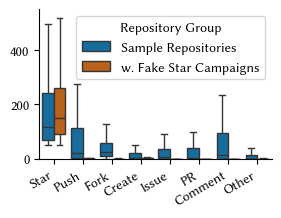

In [3]:
fig, ax = plt.subplots(figsize=(W / 2, H))
sns.boxplot(
    x="event",
    y="count",
    data=repo_event_counts[
        repo_event_counts.repo.isin(repos_with_campaign) | (repo_event_counts.group == "Samples")
    ],
    hue="group",
    hue_order=["Samples", "Suspected Fakes"],
    order=plot.EVENT_ORDER,
    palette=["C0", "C2"],
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(title="Repository Group", handles=handles, labels=["Sample Repositories", "w. Fake Star Campaigns"])
ax.set_ylim(0, 550)
#ax.set_yscale("log")
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/repo-events.pdf", bbox_inches="tight", dpi=300)

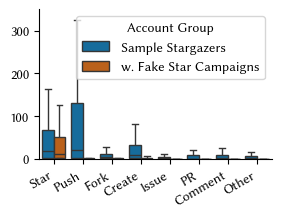

In [4]:
fig, ax = plt.subplots(figsize=(W/2, H))
sns.boxplot(
    x="event",
    y="count",
    data=actor_event_counts[
        actor_event_counts.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
        | (actor_event_counts.group == "Samples")
    ],
    hue="group",
    order=plot.EVENT_ORDER,
    hue_order=["Samples", "Suspected Fakes"],
    palette=["C0", "C2"],
    # errorbar="sd",
    showfliers=False,
    ax=ax,
)
ax.set_ylabel("")
ax.set_xlabel("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(title="Account Group", handles=handles, labels=["Sample Stargazers", "w. Fake Star Campaigns"])
ax.set_ylim(0, 350)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate()
fig.savefig("plots/actor-events.pdf", bbox_inches="tight", dpi=300)

In [5]:
X_fake_actor = (
    actor_event_percentages[
        (actor_event_percentages.group == "Suspected Fakes")
        & actor_event_percentages.actor.isin(
            clustered_actors_in_campaign | low_activity_actors_in_campaign
        )
    ]
    .drop(columns="group")
    .pivot(columns="event", index="actor", values="percentage")
)
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(X_fake_actor)
centers = defaultdict(list)
for i, cluster in enumerate(kmeans_model.labels_):
    centers.setdefault(cluster, []).append(X_fake_actor.to_numpy()[i])
centers = {k: (len(v), list(np.mean(v, axis=0))) for k, v in centers.items()}
print(X_fake_actor.columns)
for k, (n, center) in centers.items():
    print(k, n, [f"{c:.4f}" for c in center])

Index(['Comment', 'Create', 'Fork', 'Issue', 'Other', 'PR', 'Push', 'Star'], dtype='object', name='event')
1 1391 ['0.0025', '0.0210', '0.0069', '0.0021', '0.0011', '0.0008', '0.0100', '0.9556']
0 264 ['0.0279', '0.1794', '0.0255', '0.0157', '0.0325', '0.0292', '0.4044', '0.2855']
2 134 ['0.0024', '0.0176', '0.4374', '0.0051', '0.0034', '0.0001', '0.0108', '0.5234']
